# Focal Loss With U-Net Model for Image Segmentation Using TensorFlow and GCP Data Integration

## Overview
This Colab notebook implements and trains a U-Net model for semantic image segmentation. The dataset consists of multi-band satellite images (`sentinel-tiles`) and their corresponding binary masks (`mask-tiles`). The workflow integrates with a Google Cloud Storage (GCP) bucket to stream data directly for training, validation, and testing.

### Key Features:
1. **Data Streaming from GCP**:
   - Images and masks are organized in the GCP bucket into `train`, `dev`, and `test` subfolders under quarterly directories (`q1`, `q2`, etc.).
   - Data is streamed dynamically to avoid loading large datasets entirely into memory.
   - Images are resized to a target size (e.g., `128x128`) and normalized.

2. **Model Architecture**:
   - The U-Net model, a popular architecture for image segmentation tasks, is used.
   - Key components:
     - **Contracting Path (Encoder)**: Captures spatial features through convolutional and max-pooling layers.
     - **Expanding Path (Decoder)**: Restores spatial resolution via transposed convolutions and concatenates with features from the encoder via skip connections.
     - The model output is a binary mask prediction with the same spatial dimensions as the input image.

3. **Training and Optimization**:
   - Loss Function: **Focal Loss** is used for binary mask prediction tasks.
   - Optimizer: **Adam Optimizer** for adaptive learning rate control.
   - Evaluation Metric: **Accuracy** to monitor segmentation performance.
   - Early Stopping: Halts training if validation loss does not improve for 5 consecutive epochs, restoring the best weights to prevent overfitting.

4. **Data Pipeline**:
   - Training, validation, and test datasets are created using TensorFlow's `tf.data.Dataset` from a custom generator function.
   - The dataset is preprocessed to normalize pixel values, handle missing masks, and resize images and masks to a fixed shape.

5. **Training Parameters**:
   - **Batch Size**: 128 (modifiable based on system memory).
   - **Target Image Size**: 128x128 pixels with 9 channels (for satellite imagery).
   - **Epochs**: Up to 200 with early stopping.

6. **Visualization**:
   - Loss curves for both training and validation datasets are plotted to monitor convergence.
   - The epoch where training stopped is displayed.

7. **Evaluation**:
   - The test dataset is used to evaluate the final model's performance, providing a test loss and accuracy score.

### Workflow Outline:
1. **Stream Data from GCP**:
   - Dynamically load and preprocess satellite images and masks from GCP bucket paths.
   - Handle missing or mismatched images/masks gracefully.

2. **Model Training**:
   - Train the U-Net model on the training dataset.
   - Validate on the dev dataset and implement early stopping to optimize performance.

3. **Evaluation**:
   - Evaluate the trained model on the test dataset.
   - Display test accuracy and loss metrics for performance benchmarking.



# Runtime Requirements

In [ ]:
# Install required libraries
!pip install google-cloud-storage tensorflow tensorflow-addons rasterio
from google.cloud import storage
import tensorflow as tf
import numpy as np
import rasterio
from PIL import Image
import io
import os
import matplotlib.pyplot as plt

# Mount Drive and Authenticate with Google Cloud
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title OPTIONAL Sanity Check: Find Examples of Pineapple Plantations in Test Set

# NOTE: This code is purely for visualization purposes if you are interested in knowing which tiles in the test set contain plantations
def find_all_masks_with_ones(bucket_name, source_mask_prefix):
    """
    Finds and prints the paths of all masks in the 'q1/test' folder of a GCP bucket
    that contain at least one pixel with the value 1.

    Args:
        bucket_name (str): Name of the GCP bucket.
        source_mask_prefix (str): Prefix for the mask files (e.g., 'mask-tiles/').
    """
    # Initialize GCP storage client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Get list of blobs in the 'q1/test' folder
    mask_blobs = list(bucket.list_blobs(prefix=f"{source_mask_prefix}test/q1/"))
    masks_with_ones = []

    for blob in mask_blobs:
        # Download the mask file locally
        local_filename = f"/tmp/{blob.name.split('/')[-1]}"  # Use a temporary file
        blob.download_to_filename(local_filename)

        # Open the mask file using rasterio
        with rasterio.open(local_filename) as src:
            mask_data = src.read(1)  # Read the first band

            # Check if there is any value of 1 in the mask
            if (mask_data == 1).any():
                masks_with_ones.append(blob.name)

        # Remove the local file after processing (optional cleanup)
        os.remove(local_filename)

    # Print the paths of all masks with 1s
    if masks_with_ones:
        print("Masks with 1s found:")
        for mask_path in masks_with_ones:
            print(mask_path)
    else:
        print("No masks with 1s found in the 'q1/test' folder.")

# Example usage
bucket_name = "230-project-tiles"
source_mask_prefix = "mask-tiles/"
find_all_masks_with_ones(bucket_name, source_mask_prefix)


KeyboardInterrupt: 

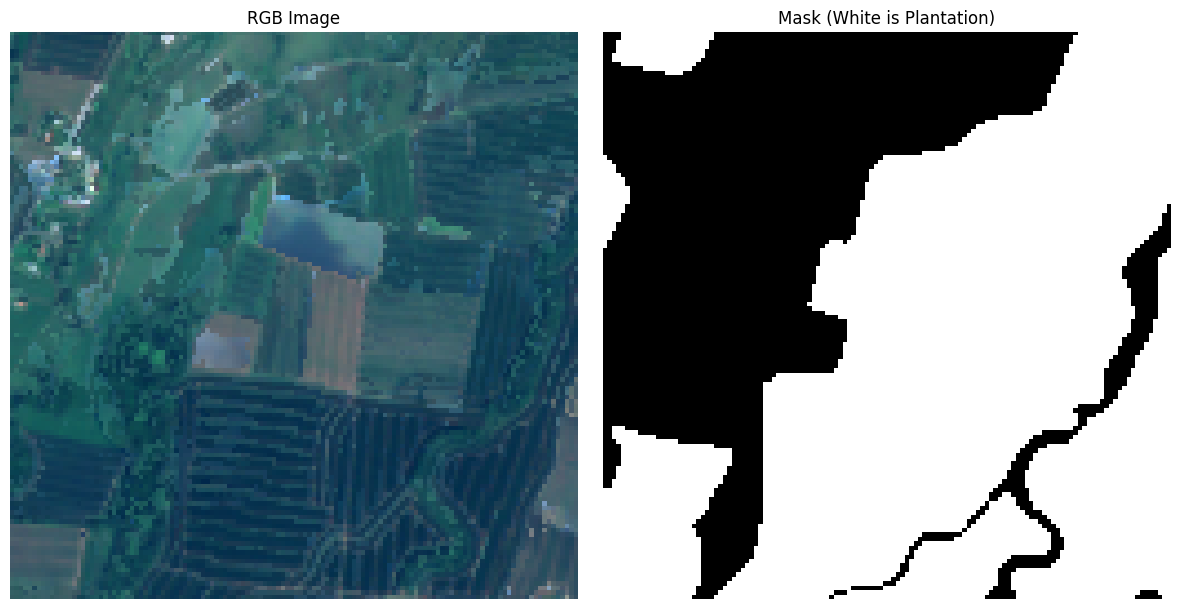

In [ ]:
#@title Visualize An Example Plantation and Mask


# Inputs:
bucket_name = "230-project-tiles" # GCP bucket name
image_blob = "sentinel-tiles-harmonized/test/q1/image_q1_2019_tile_3072_2048.tif" # path to image tile to visualize
mask_blob = "mask-tiles-harmonized/test/q1/mask_q1_2019_tile_3072_2048.tif" # path to mask tile to visualize
# note that both image_blob and mask_blob can be retrived from the optional section below


def download_from_gcp(bucket_name, blob_name, local_path):
    """
    Download a file from a GCP bucket to a local path.

    Args:
        bucket_name (str): Name of the GCP bucket.
        blob_name (str): Path to the file in the bucket.
        local_path (str): Local path to save the downloaded file.
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_path)

def visualize_image_and_mask_from_gcp(bucket_name, image_blob, mask_blob):
    """
    Download and visualize an RGB image and its corresponding mask from a GCP bucket.

    Args:
        bucket_name (str): Name of the GCP bucket.
        image_blob (str): Path to the image in the bucket.
        mask_blob (str): Path to the mask in the bucket.
    """
    # Temporary local paths
    local_image_path = "/tmp/image.tif"
    local_mask_path = "/tmp/mask.tif"

    # Download the image and mask
    download_from_gcp(bucket_name, image_blob, local_image_path)
    download_from_gcp(bucket_name, mask_blob, local_mask_path)

    # Load the RGB image
    with rasterio.open(local_image_path) as src:
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)
        rgb_image = np.dstack((red, green, blue))  # Stack bands in RGB order

        # Normalize for visualization
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Load the mask
    with rasterio.open(local_mask_path) as src:
        mask = src.read(1)

    # Visualize the image and mask
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # RGB Image
    axs[0].imshow(rgb_image)
    axs[0].set_title("RGB Image")
    axs[0].axis("off")

    # Mask in Black and White
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask (White is Plantation)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Clean up temporary files
    os.remove(local_image_path)
    os.remove(local_mask_path)
visualize_image_and_mask_from_gcp(bucket_name, image_blob, mask_blob)


# Streaming Data from GCP Bucket

In [ ]:
# Note for Noramlization: the min and max values from the bands are retrieved from the following GEE code: https://code.earthengine.google.com/adb190fa3174ce71e80fb08af0635504

def stream_data_from_gcp(bucket_name, image_prefix, mask_prefix, target_size=(128, 128, 9)):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    for quarter in ['q1/', 'q2/', 'q3/', 'q4/']:
        # List blobs
        image_blobs = [blob for blob in bucket.list_blobs(prefix=f"{image_prefix}{quarter}") if blob.name.endswith('.tif')]
        mask_blobs = [blob for blob in bucket.list_blobs(prefix=f"{mask_prefix}{quarter}") if blob.name.endswith('.tif')]

        mask_blob_dict = {blob.name.split('/')[-1].replace("mask_", "image_"): blob for blob in mask_blobs}

        for image_blob in image_blobs:
            image_name = image_blob.name.split('/')[-1]
            if image_name not in mask_blob_dict:
                print(f"Missing mask for image: {image_blob.name}")
                continue

            try:
                # Download image and mask
                image_data = image_blob.download_as_bytes()
                mask_data = mask_blob_dict[image_name].download_as_bytes()

                # Read image
                with rasterio.open(io.BytesIO(image_data)) as img:
                    image = img.read()  # Read all bands, shape = (bands, height, width)
                    image = np.moveaxis(image, 0, -1)  # Convert to (height, width, bands)

                # Read mask
                with rasterio.open(io.BytesIO(mask_data)) as msk:
                    mask = msk.read(1)  # Read the first band (single-channel mask)

                # Replace NaN values
                image = np.nan_to_num(image, nan=0)
                mask = np.nan_to_num(mask, nan=0)

                # Ensure mask has a channel dimension
                if len(mask.shape) == 2:  # If the mask is 2D
                    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension


                # Resize images and masks
                image = tf.image.resize_with_pad(image, target_size[0], target_size[1]).numpy()
                mask = tf.image.resize_with_pad(mask, target_size[0], target_size[1]).numpy()


                # Yield the processed image and mask
                yield image, mask

            except Exception as e:
                print(f"Error processing file {image_blob.name}: {e}")


In [ ]:
def create_dataset(bucket_name, image_prefix, mask_prefix, batch_size=64, buffer_size=100):
    def generator():
        return stream_data_from_gcp(bucket_name, image_prefix, mask_prefix)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 9), dtype=tf.float32),
            tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32)
        )
    )

    # Batch and repeat
    dataset = (
        dataset
        .shuffle(buffer_size)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataset

In [ ]:
train_dataset = create_dataset(
    '230-project-tiles', "sentinel-tiles-harmonized/train/", "mask-tiles-harmonized/train/", batch_size=64
)
count = 0
for batch_images, batch_masks in train_dataset.take(1):  # Take one batch
    # Extract a single image and mask from the batch
    single_image = batch_images[0]  # First image in the batch
    single_mask = batch_masks[0]    # First mask in the batch

    min_per_band = tf.reduce_min(single_image, axis=[0, 1])  # Reduce along height and width
    max_per_band = tf.reduce_max(single_image, axis=[0, 1])  # Reduce along height and width

    print("Min per band:", min_per_band.numpy())
    print("Max per band:", max_per_band.numpy())


# Model Architecture

In [ ]:
""""def unet_model(input_shape=(128, 128, 9)):
    inputs = tf.keras.layers.Input(input_shape)

    # Downsampling
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Upsampling
    u1 = tf.keras.layers.UpSampling2D((2, 2))(b)
    u1 = tf.keras.layers.Concatenate()([u1, c2])
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = tf.keras.layers.UpSampling2D((2, 2))(c3)
    u2 = tf.keras.layers.Concatenate()([u2, c1])
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation=None)(c4)

    model = tf.keras.Model(inputs, outputs)
    return model"""
def unet_model(input_shape=(128, 128, 9)):
    inputs = tf.keras.layers.Input(input_shape)

    # Downsampling
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Upsampling
    u1 = tf.keras.layers.UpSampling2D((2, 2))(b)
    u1 = tf.keras.layers.Concatenate()([u1, c2])
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = tf.keras.layers.UpSampling2D((2, 2))(c3)
    u2 = tf.keras.layers.Concatenate()([u2, c1])
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = tf.keras.Model(inputs, outputs)
    return model



# Model Training Parameters + Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, AUC

# Parameters
bucket_name = "230-project-tiles"
image_prefix = "sentinel-tiles-harmonized/"
mask_prefix = "mask-tiles-harmonized/"
batch_size = 64
epoch_num = 50

# Create dataset
# Training dataset
train_dataset = create_dataset(
    bucket_name, "sentinel-tiles-harmonized/train/", "mask-tiles-harmonized/train/", batch_size=batch_size
)

# Dev dataset
dev_dataset = create_dataset(
    bucket_name, "sentinel-tiles-harmonized/dev/", "mask-tiles-harmonized/dev/", batch_size=batch_size
)

"""# Define the U-Net model
model = unet_model()
from tensorflow.keras.utils import plot_model

# Create the U-Net model
model = unet_model(input_shape=(128, 128, 9))
model.summary()

from tensorflow.keras.losses import BinaryFocalCrossentropy

# Create the loss object
focal_loss = BinaryFocalCrossentropy(
    apply_class_balancing=False,  # Manually handle class weights if needed
    alpha=0.25,                  # Balancing factor (set based on your dataset)
    gamma=2.0,                   # Focusing parameter
    from_logits=False,           # Use False if your output layer has sigmoid activation
    reduction='sum_over_batch_size',  # Default reduction
    name='binary_focal_crossentropy'
)

# Add AUC (ROC-AUC) metric
model.compile(
    optimizer='adam',
    loss= focal_loss,
    metrics=[
        'accuracy',                 # Accuracy
        AUC(name="roc_auc", curve='ROC'),  # ROC-AUC metric
        Precision(name="precision"),       # Precision
        Recall(name="recall")              # Recall
    ]
)
"""
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",         # Monitor validation loss (dev set error)
    patience=5,                 # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Restore the weights of the best epoch
    mode="min"                  # Minimize validation loss
)
# Set up the ModelCheckpoint callback to save only the most recent model
checkpoint_callback = ModelCheckpoint(
    filepath='model_latest.keras',  # Single file name, overwrites after each epoch
    save_best_only=False,        # Save after every epoch, not just the best one
    save_weights_only=False,     # Save the full model (architecture + weights)
    verbose=1                    # Print a message when saving
)

class TrainValMetrics(Callback):
    def on_train_batch_end(self, batch, logs=None):
        # Training metrics for the current batch
        train_loss = logs.get("loss")
        train_accuracy = logs.get("accuracy")
        print(f"Batch {batch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}")

    def on_epoch_end(self, epoch, logs=None):
        # Training metrics (aggregated over the epoch)
        train_loss = logs.get("loss")
        train_accuracy = logs.get("accuracy")

        # Validation metrics (aggregated over the epoch)
        val_loss = logs.get("val_loss")
        val_accuracy = logs.get("val_accuracy")
        val_precision = logs.get("val_precision")
        val_recall = logs.get("val_recall")

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
              f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}, "
              f"Validation Precision = {val_precision:.4f}, Validation Recall = {val_recall:.4f}")

train_val_metrics = TrainValMetrics()


# Model Training and Export


Epoch 1/50
Batch 1: Train Loss = 0.1835, Train Accuracy = 0.0645
      1/Unknown 32s 32s/step - accuracy: 0.0645 - loss: 0.1835 - precision: 0.0531 - recall: 0.9810 - roc_auc: 0.4634Batch 2: Train Loss = 0.1398, Train Accuracy = 0.4758
      2/Unknown 43s 10s/step - accuracy: 0.2701 - loss: 0.1616 - precision: 0.0531 - recall: 0.6480 - roc_auc: 0.4335Batch 3: Train Loss = 0.1192, Train Accuracy = 0.6236
      3/Unknown 55s 11s/step - accuracy: 0.3879 - loss: 0.1475 - precision: 0.0531 - recall: 0.5027 - roc_auc: 0.4441Batch 4: Train Loss = 0.1820, Train Accuracy = 0.6948
      4/Unknown 67s 11s/step - accuracy: 0.4647 - loss: 0.1561 - precision: 0.0531 - recall: 0.4157 - roc_auc: 0.4519Batch 5: Train Loss = 0.1667, Train Accuracy = 0.7291
      5/Unknown 78s 12s/step - accuracy: 0.5176 - loss: 0.1582 - precision: 0.0531 - recall: 0.3547 - roc_auc: 0.4592Batch 6: Train Loss = 0.1587, Train Accuracy = 0.7539
      6/Unknown 90s 12s/step - accuracy: 0.5569 - loss: 0.1583 - precision: 0.05

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: saving model to model_latest.keras
Epoch 1: Train Loss = 0.0475, Train Accuracy = 0.9421, Validation Loss = 0.4027, Validation Accuracy = 0.9563, Validation Precision = 0.0000, Validation Recall = 0.0000


<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 1211s 16s/step - accuracy: 0.8617 - loss: 0.0907 - precision: 0.0531 - recall: 0.0428 - roc_auc: 0.6918 - val_accuracy: 0.9563 - val_loss: 0.4027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5064
Epoch 2/50
Batch 1: Train Loss = 0.6757, Train Accuracy = 0.9257
 1/76 ━━━━━━━━━━━━━━━━━━━━ 30:08 24s/step - accuracy: 0.9257 - loss: 0.6757 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5106Batch 2: Train Loss = 0.6681, Train Accuracy = 0.9159
 2/76 ━━━━━━━━━━━━━━━━━━━━ 13:36 11s/step - accuracy: 0.9208 - loss: 0.6719 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5089Batch 3: Train Loss = 0.5267, Train Accuracy = 0.9252
 3/76 ━━━━━━━━━━━━━━━━━━━━ 13:13 11s/step - accuracy: 0.9223 - loss: 0.6235 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5372Batch 4: Train Loss = 0.4544, Train Accuracy = 0.9186
 4/76 ━━━━━━━━━━━━━━━━━━━━ 13:04 11s/step - accuracy: 0.9213 - loss: 0.5812 - precision: 0.0000e+00 - recall: 0

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 1080s 14s/step - accuracy: 0.9180 - loss: 0.1692 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6473 - val_accuracy: 0.9563 - val_loss: 0.3798 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5002
Epoch 3/50
Batch 1: Train Loss = 0.8735, Train Accuracy = 0.8987
 1/76 ━━━━━━━━━━━━━━━━━━━━ 30:30 24s/step - accuracy: 0.8987 - loss: 0.8735 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5008Batch 2: Train Loss = 0.6813, Train Accuracy = 0.9093
 2/76 ━━━━━━━━━━━━━━━━━━━━ 11:52 10s/step - accuracy: 0.9040 - loss: 0.7774 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5051Batch 3: Train Loss = 0.5278, Train Accuracy = 0.9213
 3/76 ━━━━━━━━━━━━━━━━━━━━ 11:37 10s/step - accuracy: 0.9098 - loss: 0.6942 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4950Batch 4: Train Loss = 0.4610, Train Accuracy = 0.9108
 4/76 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - accuracy: 0.9100 - loss: 0.6359 - precision: 0.0000e+00 - re

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 930s 12s/step - accuracy: 0.9174 - loss: 0.1827 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6056 - val_accuracy: 0.9563 - val_loss: 4.8039 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 4/50
Batch 1: Train Loss = 9.4255, Train Accuracy = 0.9130
 1/76 ━━━━━━━━━━━━━━━━━━━━ 31:36 25s/step - accuracy: 0.9130 - loss: 9.4255 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 6.1365, Train Accuracy = 0.9191
 2/76 ━━━━━━━━━━━━━━━━━━━━ 12:18 10s/step - accuracy: 0.9160 - loss: 7.7810 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5003Batch 3: Train Loss = 4.2821, Train Accuracy = 0.9204
 3/76 ━━━━━━━━━━━━━━━━━━━━ 11:53 10s/step - accuracy: 0.9175 - loss: 6.6147 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5137Batch 4: Train Loss = 3.2257, Train Accuracy = 0.9199
 4/76 ━━━━━━━━━━━━━━━━━━━━ 11:38 10s/step - accuracy: 0.9181 - loss: 5.7675 - precision: 0.0000e+00 - re

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 900s 12s/step - accuracy: 0.9178 - loss: 0.8500 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6504 - val_accuracy: 0.9563 - val_loss: 2.1133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 5/50
Batch 1: Train Loss = 3.7447, Train Accuracy = 0.9235
 1/76 ━━━━━━━━━━━━━━━━━━━━ 27:17 22s/step - accuracy: 0.9235 - loss: 3.7447 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 2.3296, Train Accuracy = 0.9382
 2/76 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - accuracy: 0.9309 - loss: 3.0372 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001 Batch 3: Train Loss = 1.7382, Train Accuracy = 0.9304
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - accuracy: 0.9307 - loss: 2.6042 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5015Batch 4: Train Loss = 1.3191, Train Accuracy = 0.9371
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - accuracy: 0.9323 - loss: 2.2829 - precision: 0.0000e+00 - reca

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 787s 10s/step - accuracy: 0.9185 - loss: 0.3749 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6669 - val_accuracy: 0.9563 - val_loss: 3.7672 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 6/50
Batch 1: Train Loss = 9.6136, Train Accuracy = 0.8889
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:41 20s/step - accuracy: 0.8889 - loss: 9.6136 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 5.9237, Train Accuracy = 0.9154
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:25 8s/step - accuracy: 0.9021 - loss: 7.7686 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 4.2304, Train Accuracy = 0.9230
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:22 8s/step - accuracy: 0.9091 - loss: 6.5892 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 3.2944, Train Accuracy = 0.9089
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:18 8s/step - accuracy: 0.9091 - loss: 5.7655 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 720s 9s/step - accuracy: 0.9173 - loss: 0.8577 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6370 - val_accuracy: 0.9563 - val_loss: 1.0422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4998
Epoch 7/50
Batch 1: Train Loss = 1.5299, Train Accuracy = 0.9400
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:45 20s/step - accuracy: 0.9400 - loss: 1.5299 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5009Batch 2: Train Loss = 1.1562, Train Accuracy = 0.9342
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:56 7s/step - accuracy: 0.9371 - loss: 1.3430 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5014  Batch 3: Train Loss = 0.8669, Train Accuracy = 0.9301
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:07 8s/step - accuracy: 0.9348 - loss: 1.1843 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5004Batch 4: Train Loss = 0.6786, Train Accuracy = 0.9196
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:15 8s/step - accuracy: 0.9310 - loss: 1.0579 - precision: 0.0000e+00 - recall:

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 676s 9s/step - accuracy: 0.9182 - loss: 0.2226 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6395 - val_accuracy: 0.9563 - val_loss: 3.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 8/50
Batch 1: Train Loss = 8.5021, Train Accuracy = 0.9027
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:25 20s/step - accuracy: 0.9027 - loss: 8.5021 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 5.5104, Train Accuracy = 0.9107
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:51 7s/step - accuracy: 0.9067 - loss: 7.0062 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 3.8417, Train Accuracy = 0.9209
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:47 7s/step - accuracy: 0.9114 - loss: 5.9514 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 4: Train Loss = 2.9208, Train Accuracy = 0.9259
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:27 7s/step - accuracy: 0.9150 - loss: 5.1937 - precision: 0.0000e+00 - recall:

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 637s 8s/step - accuracy: 0.9177 - loss: 0.7667 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6264 - val_accuracy: 0.9563 - val_loss: 0.9505 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 9/50
Batch 1: Train Loss = 2.1004, Train Accuracy = 0.9026
 1/76 ━━━━━━━━━━━━━━━━━━━━ 22:14 18s/step - accuracy: 0.9026 - loss: 2.1004 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5004Batch 2: Train Loss = 1.2706, Train Accuracy = 0.9311
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:31 7s/step - accuracy: 0.9168 - loss: 1.6855 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4984  Batch 3: Train Loss = 0.9264, Train Accuracy = 0.9372
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:41 7s/step - accuracy: 0.9236 - loss: 1.4325 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4861Batch 4: Train Loss = 0.7389, Train Accuracy = 0.9286
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:25 7s/step - accuracy: 0.9249 - loss: 1.2591 - precision: 0.0000e+00 - recall:

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 609s 8s/step - accuracy: 0.9182 - loss: 0.2534 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5371 - val_accuracy: 0.9563 - val_loss: 0.5433 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 10/50
Batch 1: Train Loss = 1.1240, Train Accuracy = 0.9091
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:12 19s/step - accuracy: 0.9091 - loss: 1.1240 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5015Batch 2: Train Loss = 0.8805, Train Accuracy = 0.9198
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:53 7s/step - accuracy: 0.9144 - loss: 1.0023 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5011  Batch 3: Train Loss = 0.7126, Train Accuracy = 0.9262
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:23 7s/step - accuracy: 0.9184 - loss: 0.9057 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4999Batch 4: Train Loss = 0.6436, Train Accuracy = 0.9167
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:36 7s/step - accuracy: 0.9179 - loss: 0.8402 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 608s 8s/step - accuracy: 0.9183 - loss: 0.2100 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5652 - val_accuracy: 0.9563 - val_loss: 0.8626 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4998
Epoch 11/50
Batch 1: Train Loss = 1.4014, Train Accuracy = 0.9286
 1/76 ━━━━━━━━━━━━━━━━━━━━ 20:41 17s/step - accuracy: 0.9286 - loss: 1.4014 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5019Batch 2: Train Loss = 1.0707, Train Accuracy = 0.9355
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:05 7s/step - accuracy: 0.9320 - loss: 1.2361 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5027  Batch 3: Train Loss = 0.8939, Train Accuracy = 0.9339
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:56 7s/step - accuracy: 0.9327 - loss: 1.1220 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5021Batch 4: Train Loss = 0.7532, Train Accuracy = 0.9302
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:43 6s/step - accuracy: 0.9321 - loss: 1.0298 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 563s 7s/step - accuracy: 0.9191 - loss: 0.2387 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5740 - val_accuracy: 0.9563 - val_loss: 1.6851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 12/50
Batch 1: Train Loss = 3.0619, Train Accuracy = 0.9207
 1/76 ━━━━━━━━━━━━━━━━━━━━ 22:01 18s/step - accuracy: 0.9207 - loss: 3.0619 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 2.4971, Train Accuracy = 0.9261
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:55 6s/step - accuracy: 0.9234 - loss: 2.7795 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 2.1270, Train Accuracy = 0.9262
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:48 6s/step - accuracy: 0.9243 - loss: 2.5620 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 1.7708, Train Accuracy = 0.9290
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:44 6s/step - accuracy: 0.9255 - loss: 2.3642 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 562s 7s/step - accuracy: 0.9181 - loss: 0.5030 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5683 - val_accuracy: 0.9563 - val_loss: 0.0585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4998
Epoch 13/50
Batch 1: Train Loss = 0.0838, Train Accuracy = 0.9079
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:24 17s/step - accuracy: 0.9079 - loss: 0.0838 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4998Batch 2: Train Loss = 0.0823, Train Accuracy = 0.9106
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:50 6s/step - accuracy: 0.9092 - loss: 0.0830 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4998  Batch 3: Train Loss = 0.0747, Train Accuracy = 0.9251
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:55 7s/step - accuracy: 0.9145 - loss: 0.0803 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4997Batch 4: Train Loss = 0.0755, Train Accuracy = 0.9235
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:59 7s/step - accuracy: 0.9168 - loss: 0.0791 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 553s 7s/step - accuracy: 0.9178 - loss: 0.0778 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5905 - val_accuracy: 0.9563 - val_loss: 0.0539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 14/50
Batch 1: Train Loss = 0.0750, Train Accuracy = 0.9223
 1/76 ━━━━━━━━━━━━━━━━━━━━ 22:15 18s/step - accuracy: 0.9223 - loss: 0.0750 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0735, Train Accuracy = 0.9248
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:02 7s/step - accuracy: 0.9235 - loss: 0.0742 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0728, Train Accuracy = 0.9259
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:34 7s/step - accuracy: 0.9243 - loss: 0.0737 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0768, Train Accuracy = 0.9194
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:22 7s/step - accuracy: 0.9231 - loss: 0.0745 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 565s 7s/step - accuracy: 0.9180 - loss: 0.0776 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4730 - val_accuracy: 0.9563 - val_loss: 0.0522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 15/50
Batch 1: Train Loss = 0.0862, Train Accuracy = 0.9068
 1/76 ━━━━━━━━━━━━━━━━━━━━ 20:43 17s/step - accuracy: 0.9068 - loss: 0.0862 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0726, Train Accuracy = 0.9266
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:32 6s/step - accuracy: 0.9167 - loss: 0.0794 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0744, Train Accuracy = 0.9240
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:31 6s/step - accuracy: 0.9191 - loss: 0.0777 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4960Batch 4: Train Loss = 0.0727, Train Accuracy = 0.9264
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:29 6s/step - accuracy: 0.9210 - loss: 0.0765 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 531s 7s/step - accuracy: 0.9182 - loss: 0.0785 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4135 - val_accuracy: 0.9563 - val_loss: 0.0515 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 16/50
Batch 1: Train Loss = 0.0859, Train Accuracy = 0.9093
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:25 20s/step - accuracy: 0.9093 - loss: 0.0859 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0775, Train Accuracy = 0.9208
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:48 6s/step - accuracy: 0.9151 - loss: 0.0817 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5196  Batch 3: Train Loss = 0.0726, Train Accuracy = 0.9275
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:56 7s/step - accuracy: 0.9192 - loss: 0.0787 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5281Batch 4: Train Loss = 0.0839, Train Accuracy = 0.9122
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:52 7s/step - accuracy: 0.9175 - loss: 0.0800 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 529s 7s/step - accuracy: 0.9176 - loss: 0.0801 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4117 - val_accuracy: 0.9563 - val_loss: 0.0513 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 17/50
Batch 1: Train Loss = 0.0874, Train Accuracy = 0.9089
 1/76 ━━━━━━━━━━━━━━━━━━━━ 29:01 23s/step - accuracy: 0.9089 - loss: 0.0874 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0693, Train Accuracy = 0.9327
 2/76 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - accuracy: 0.9208 - loss: 0.0783 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0747, Train Accuracy = 0.9255
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - accuracy: 0.9224 - loss: 0.0771 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0797, Train Accuracy = 0.9191
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:08 8s/step - accuracy: 0.9215 - loss: 0.0778 - precision: 0.0000e+00 - reca

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 604s 8s/step - accuracy: 0.9179 - loss: 0.0807 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3829 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 18/50
Batch 1: Train Loss = 0.0864, Train Accuracy = 0.9112
 1/76 ━━━━━━━━━━━━━━━━━━━━ 28:46 23s/step - accuracy: 0.9112 - loss: 0.0864 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0786, Train Accuracy = 0.9211
 2/76 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - accuracy: 0.9162 - loss: 0.0825 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0749, Train Accuracy = 0.9260
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - accuracy: 0.9194 - loss: 0.0800 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4999Batch 4: Train Loss = 0.0747, Train Accuracy = 0.9262
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - accuracy: 0.9211 - loss: 0.0787 - precision: 0.0000e+00 - reca

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 683s 9s/step - accuracy: 0.9186 - loss: 0.0808 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4115 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 19/50
Batch 1: Train Loss = 0.0807, Train Accuracy = 0.9190
 1/76 ━━━━━━━━━━━━━━━━━━━━ 28:08 23s/step - accuracy: 0.9190 - loss: 0.0807 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0671, Train Accuracy = 0.9362
 2/76 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - accuracy: 0.9276 - loss: 0.0739 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0640, Train Accuracy = 0.9401
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - accuracy: 0.9318 - loss: 0.0706 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0701, Train Accuracy = 0.9324
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - accuracy: 0.9319 - loss: 0.0705 - precision: 0.0000e+00 - reca

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 695s 9s/step - accuracy: 0.9182 - loss: 0.0815 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3810 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 20/50
Batch 1: Train Loss = 0.0954, Train Accuracy = 0.9009
 1/76 ━━━━━━━━━━━━━━━━━━━━ 29:48 24s/step - accuracy: 0.9009 - loss: 0.0954 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 2: Train Loss = 0.0641, Train Accuracy = 0.9400
 2/76 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - accuracy: 0.9205 - loss: 0.0798 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001 Batch 3: Train Loss = 0.0780, Train Accuracy = 0.9228
 3/76 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - accuracy: 0.9213 - loss: 0.0792 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4733Batch 4: Train Loss = 0.0791, Train Accuracy = 0.9215
 4/76 ━━━━━━━━━━━━━━━━━━━━ 11:28 10s/step - accuracy: 0.9213 - loss: 0.0792 - precision: 0.0000e+00 - rec

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 769s 10s/step - accuracy: 0.9181 - loss: 0.0818 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3865 - val_accuracy: 0.9563 - val_loss: 0.0511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 21/50
Batch 1: Train Loss = 0.1028, Train Accuracy = 0.8921
 1/76 ━━━━━━━━━━━━━━━━━━━━ 26:03 21s/step - accuracy: 0.8921 - loss: 0.1028 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0849, Train Accuracy = 0.9143
 2/76 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - accuracy: 0.9032 - loss: 0.0939 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0796, Train Accuracy = 0.9210
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - accuracy: 0.9091 - loss: 0.0891 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0796, Train Accuracy = 0.9210
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - accuracy: 0.9121 - loss: 0.0867 - precision: 0.0000e+00 - rec

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 765s 10s/step - accuracy: 0.9173 - loss: 0.0827 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3982 - val_accuracy: 0.9563 - val_loss: 0.0511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 22/50
Batch 1: Train Loss = 0.0894, Train Accuracy = 0.9089
 1/76 ━━━━━━━━━━━━━━━━━━━━ 29:51 24s/step - accuracy: 0.9089 - loss: 0.0894 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0764, Train Accuracy = 0.9251
 2/76 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - accuracy: 0.9170 - loss: 0.0829 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0731, Train Accuracy = 0.9291
 3/76 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - accuracy: 0.9210 - loss: 0.0796 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0789, Train Accuracy = 0.9220
 4/76 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - accuracy: 0.9213 - loss: 0.0795 - precision: 0.0000e+00 - rec

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 772s 10s/step - accuracy: 0.9176 - loss: 0.0825 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4047 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 23/50
Batch 1: Train Loss = 0.0853, Train Accuracy = 0.9141
 1/76 ━━━━━━━━━━━━━━━━━━━━ 25:59 21s/step - accuracy: 0.9141 - loss: 0.0853 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0842, Train Accuracy = 0.9155
 2/76 ━━━━━━━━━━━━━━━━━━━━ 10:14 8s/step - accuracy: 0.9148 - loss: 0.0847 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 Batch 3: Train Loss = 0.0773, Train Accuracy = 0.9240
 3/76 ━━━━━━━━━━━━━━━━━━━━ 10:17 8s/step - accuracy: 0.9179 - loss: 0.0823 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0955, Train Accuracy = 0.9018
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:56 8s/step - accuracy: 0.9139 - loss: 0.0856 - precision: 0.0000e+00 - reca

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 733s 10s/step - accuracy: 0.9171 - loss: 0.0830 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3986 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 24/50
Batch 1: Train Loss = 0.0817, Train Accuracy = 0.9186
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:04 19s/step - accuracy: 0.9186 - loss: 0.0817 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0750, Train Accuracy = 0.9269
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:52 8s/step - accuracy: 0.9228 - loss: 0.0784 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0748, Train Accuracy = 0.9272
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.9243 - loss: 0.0772 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0799, Train Accuracy = 0.9209
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:05 8s/step - accuracy: 0.9234 - loss: 0.0779 - precision: 0.0000e+00 - recal

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 707s 9s/step - accuracy: 0.9185 - loss: 0.0820 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3954 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 25/50
Batch 1: Train Loss = 0.0878, Train Accuracy = 0.9112
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:18 19s/step - accuracy: 0.9112 - loss: 0.0878 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0799, Train Accuracy = 0.9210
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:11 7s/step - accuracy: 0.9161 - loss: 0.0838 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0726, Train Accuracy = 0.9300
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:17 7s/step - accuracy: 0.9207 - loss: 0.0801 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0797, Train Accuracy = 0.9213
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:21 7s/step - accuracy: 0.9208 - loss: 0.0800 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 650s 8s/step - accuracy: 0.9178 - loss: 0.0826 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3955 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 26/50
Batch 1: Train Loss = 0.0837, Train Accuracy = 0.9162
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:30 17s/step - accuracy: 0.9162 - loss: 0.0837 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0716, Train Accuracy = 0.9312
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:48 6s/step - accuracy: 0.9237 - loss: 0.0777 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0704, Train Accuracy = 0.9326
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:55 7s/step - accuracy: 0.9267 - loss: 0.0752 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0749, Train Accuracy = 0.9271
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:54 7s/step - accuracy: 0.9268 - loss: 0.0752 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 646s 8s/step - accuracy: 0.9187 - loss: 0.0819 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3946 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 27/50
Batch 1: Train Loss = 0.0903, Train Accuracy = 0.9082
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:14 19s/step - accuracy: 0.9082 - loss: 0.0903 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0706, Train Accuracy = 0.9324
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:04 7s/step - accuracy: 0.9203 - loss: 0.0804 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0771, Train Accuracy = 0.9244
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:32 7s/step - accuracy: 0.9217 - loss: 0.0793 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0800, Train Accuracy = 0.9209
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:23 7s/step - accuracy: 0.9215 - loss: 0.0795 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 600s 8s/step - accuracy: 0.9177 - loss: 0.0826 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3909 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 28/50
Batch 1: Train Loss = 0.0708, Train Accuracy = 0.9321
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:30 19s/step - accuracy: 0.9321 - loss: 0.0708 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0652, Train Accuracy = 0.9390
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:17 7s/step - accuracy: 0.9356 - loss: 0.0680 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0706, Train Accuracy = 0.9325
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:54 6s/step - accuracy: 0.9345 - loss: 0.0689 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0726, Train Accuracy = 0.9300
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:30 6s/step - accuracy: 0.9334 - loss: 0.0698 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 595s 8s/step - accuracy: 0.9185 - loss: 0.0821 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3906 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 29/50
Batch 1: Train Loss = 0.1024, Train Accuracy = 0.8933
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:51 17s/step - accuracy: 0.8933 - loss: 0.1024 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0787, Train Accuracy = 0.9224
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:17 7s/step - accuracy: 0.9079 - loss: 0.0906 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0715, Train Accuracy = 0.9313
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:23 7s/step - accuracy: 0.9157 - loss: 0.0842 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0812, Train Accuracy = 0.9194
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:12 7s/step - accuracy: 0.9166 - loss: 0.0835 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 606s 8s/step - accuracy: 0.9176 - loss: 0.0828 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3899 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 30/50
Batch 1: Train Loss = 0.1266, Train Accuracy = 0.8636
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:13 19s/step - accuracy: 0.8636 - loss: 0.1266 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0875, Train Accuracy = 0.9116
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:00 6s/step - accuracy: 0.8876 - loss: 0.1071 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0785, Train Accuracy = 0.9227
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:09 7s/step - accuracy: 0.8993 - loss: 0.0976 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0793, Train Accuracy = 0.9219
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:16 7s/step - accuracy: 0.9050 - loss: 0.0930 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 611s 8s/step - accuracy: 0.9170 - loss: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3879 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 31/50
Batch 1: Train Loss = 0.1146, Train Accuracy = 0.8784
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:25 17s/step - accuracy: 0.8784 - loss: 0.1146 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0916, Train Accuracy = 0.9067
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:04 7s/step - accuracy: 0.8926 - loss: 0.1031 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0807, Train Accuracy = 0.9201
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:44 6s/step - accuracy: 0.9017 - loss: 0.0956 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0817, Train Accuracy = 0.9189
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:31 6s/step - accuracy: 0.9060 - loss: 0.0922 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 528s 7s/step - accuracy: 0.9172 - loss: 0.0832 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3907 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 32/50
Batch 1: Train Loss = 0.1041, Train Accuracy = 0.8913
 1/76 ━━━━━━━━━━━━━━━━━━━━ 18:58 15s/step - accuracy: 0.8913 - loss: 0.1041 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0816, Train Accuracy = 0.9190
 2/76 ━━━━━━━━━━━━━━━━━━━━ 6:55 6s/step - accuracy: 0.9051 - loss: 0.0929 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0753, Train Accuracy = 0.9267
 3/76 ━━━━━━━━━━━━━━━━━━━━ 6:50 6s/step - accuracy: 0.9123 - loss: 0.0870 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0778, Train Accuracy = 0.9237
 4/76 ━━━━━━━━━━━━━━━━━━━━ 6:47 6s/step - accuracy: 0.9152 - loss: 0.0847 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 513s 7s/step - accuracy: 0.9181 - loss: 0.0825 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3977 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 33/50
Batch 1: Train Loss = 0.1010, Train Accuracy = 0.8952
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:51 17s/step - accuracy: 0.8952 - loss: 0.1010 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0744, Train Accuracy = 0.9278
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:35 6s/step - accuracy: 0.9115 - loss: 0.0877 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0816, Train Accuracy = 0.9191
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:45 6s/step - accuracy: 0.9140 - loss: 0.0857 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 4: Train Loss = 0.0798, Train Accuracy = 0.9213
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:39 6s/step - accuracy: 0.9158 - loss: 0.0842 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 533s 7s/step - accuracy: 0.9177 - loss: 0.0828 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3969 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 34/50
Batch 1: Train Loss = 0.0660, Train Accuracy = 0.9381
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:50 20s/step - accuracy: 0.9381 - loss: 0.0660 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 2: Train Loss = 0.0745, Train Accuracy = 0.9277
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:18 7s/step - accuracy: 0.9329 - loss: 0.0702 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001  Batch 3: Train Loss = 0.0713, Train Accuracy = 0.9316
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:16 7s/step - accuracy: 0.9325 - loss: 0.0706 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 4: Train Loss = 0.0763, Train Accuracy = 0.9256
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:10 7s/step - accuracy: 0.9308 - loss: 0.0720 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 517s 7s/step - accuracy: 0.9184 - loss: 0.0822 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3942 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 35/50
Batch 1: Train Loss = 0.0799, Train Accuracy = 0.9211
 1/76 ━━━━━━━━━━━━━━━━━━━━ 26:50 21s/step - accuracy: 0.9211 - loss: 0.0799 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 2: Train Loss = 0.0752, Train Accuracy = 0.9269
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - accuracy: 0.9240 - loss: 0.0775 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002  Batch 3: Train Loss = 0.0749, Train Accuracy = 0.9273
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:29 8s/step - accuracy: 0.9251 - loss: 0.0767 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 4: Train Loss = 0.0816, Train Accuracy = 0.9191
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:19 8s/step - accuracy: 0.9236 - loss: 0.0779 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 555s 7s/step - accuracy: 0.9182 - loss: 0.0824 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3956 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 36/50
Batch 1: Train Loss = 0.0933, Train Accuracy = 0.9046
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:46 20s/step - accuracy: 0.9046 - loss: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 2: Train Loss = 0.0832, Train Accuracy = 0.9171
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - accuracy: 0.9109 - loss: 0.0883 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002  Batch 3: Train Loss = 0.0806, Train Accuracy = 0.9203
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:23 8s/step - accuracy: 0.9140 - loss: 0.0857 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 4: Train Loss = 0.0822, Train Accuracy = 0.9185
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:07 8s/step - accuracy: 0.9151 - loss: 0.0848 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 594s 8s/step - accuracy: 0.9172 - loss: 0.0832 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3942 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 37/50
Batch 1: Train Loss = 0.1050, Train Accuracy = 0.8905
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:17 19s/step - accuracy: 0.8905 - loss: 0.1050 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 2: Train Loss = 0.0776, Train Accuracy = 0.9240
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:42 7s/step - accuracy: 0.9072 - loss: 0.0913 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001  Batch 3: Train Loss = 0.0768, Train Accuracy = 0.9250
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:33 7s/step - accuracy: 0.9131 - loss: 0.0864 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5001Batch 4: Train Loss = 0.0818, Train Accuracy = 0.9189
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:17 7s/step - accuracy: 0.9146 - loss: 0.0853 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 566s 7s/step - accuracy: 0.9182 - loss: 0.0825 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3976 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 38/50
Batch 1: Train Loss = 0.0658, Train Accuracy = 0.9383
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:16 19s/step - accuracy: 0.9383 - loss: 0.0658 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0756, Train Accuracy = 0.9264
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:29 8s/step - accuracy: 0.9324 - loss: 0.0707 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0776, Train Accuracy = 0.9240
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:33 8s/step - accuracy: 0.9296 - loss: 0.0730 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.0778, Train Accuracy = 0.9238
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:25 8s/step - accuracy: 0.9281 - loss: 0.0742 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 618s 8s/step - accuracy: 0.9187 - loss: 0.0821 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3922 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Epoch 39/50
Batch 1: Train Loss = 0.1017, Train Accuracy = 0.8945
 1/76 ━━━━━━━━━━━━━━━━━━━━ 24:31 20s/step - accuracy: 0.8945 - loss: 0.1017 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5003Batch 2: Train Loss = 0.0859, Train Accuracy = 0.9139
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:06 7s/step - accuracy: 0.9042 - loss: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002  Batch 3: Train Loss = 0.0758, Train Accuracy = 0.9262
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:58 7s/step - accuracy: 0.9115 - loss: 0.0878 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 4: Train Loss = 0.0834, Train Accuracy = 0.9170
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:47 7s/step - accuracy: 0.9129 - loss: 0.0867 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 580s 7s/step - accuracy: 0.9175 - loss: 0.0830 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3985 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5015
Epoch 40/50
Batch 1: Train Loss = 0.0845, Train Accuracy = 0.9159
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:26 17s/step - accuracy: 0.9159 - loss: 0.0845 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5054Batch 2: Train Loss = 0.0711, Train Accuracy = 0.9322
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:55 6s/step - accuracy: 0.9241 - loss: 0.0778 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5317  Batch 3: Train Loss = 0.0763, Train Accuracy = 0.9260
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:16 7s/step - accuracy: 0.9247 - loss: 0.0773 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5287Batch 4: Train Loss = 0.0830, Train Accuracy = 0.9178
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:13 7s/step - accuracy: 0.9230 - loss: 0.0787 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 658s 9s/step - accuracy: 0.9179 - loss: 0.0828 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4104 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 41/50
Batch 1: Train Loss = 0.0975, Train Accuracy = 0.8999
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:54 18s/step - accuracy: 0.8999 - loss: 0.0975 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 2: Train Loss = 0.0744, Train Accuracy = 0.9280
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:21 7s/step - accuracy: 0.9139 - loss: 0.0860 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000  Batch 3: Train Loss = 0.0777, Train Accuracy = 0.9237
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:56 7s/step - accuracy: 0.9172 - loss: 0.0832 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4999Batch 4: Train Loss = 0.0801, Train Accuracy = 0.9201
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:54 7s/step - accuracy: 0.9179 - loss: 0.0824 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 659s 9s/step - accuracy: 0.9176 - loss: 0.0749 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6334 - val_accuracy: 0.9563 - val_loss: 0.0518 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4970
Epoch 42/50
Batch 1: Train Loss = 0.0973, Train Accuracy = 0.9062
 1/76 ━━━━━━━━━━━━━━━━━━━━ 25:08 20s/step - accuracy: 0.9062 - loss: 0.0973 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4984Batch 2: Train Loss = 0.0943, Train Accuracy = 0.9095
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:58 7s/step - accuracy: 0.9078 - loss: 0.0958 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4980  Batch 3: Train Loss = 0.0813, Train Accuracy = 0.9238
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:31 7s/step - accuracy: 0.9132 - loss: 0.0909 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4981Batch 4: Train Loss = 0.0813, Train Accuracy = 0.9239
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:33 7s/step - accuracy: 0.9158 - loss: 0.0885 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 661s 9s/step - accuracy: 0.9177 - loss: 0.0856 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4475 - val_accuracy: 0.9563 - val_loss: 0.6592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4999
Epoch 43/50
Batch 1: Train Loss = 1.1126, Train Accuracy = 0.9259
 1/76 ━━━━━━━━━━━━━━━━━━━━ 30:26 24s/step - accuracy: 0.9259 - loss: 1.1126 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5002Batch 2: Train Loss = 0.9004, Train Accuracy = 0.9348
 2/76 ━━━━━━━━━━━━━━━━━━━━ 12:25 10s/step - accuracy: 0.9303 - loss: 1.0065 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4995Batch 3: Train Loss = 0.8792, Train Accuracy = 0.9256
 3/76 ━━━━━━━━━━━━━━━━━━━━ 11:51 10s/step - accuracy: 0.9288 - loss: 0.9641 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000Batch 4: Train Loss = 0.7653, Train Accuracy = 0.9273
 4/76 ━━━━━━━━━━━━━━━━━━━━ 11:29 10s/step - accuracy: 0.9284 - loss: 0.9144 - precision: 0.0000e+00 - re

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 755s 10s/step - accuracy: 0.9183 - loss: 0.2583 - precision: 0.0258 - recall: 2.5849e-05 - roc_auc: 0.5339 - val_accuracy: 0.9563 - val_loss: 0.3207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4995
Epoch 44/50
Batch 1: Train Loss = 0.6275, Train Accuracy = 0.9149
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:55 18s/step - accuracy: 0.9149 - loss: 0.6275 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4972Batch 2: Train Loss = 0.5812, Train Accuracy = 0.9089
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:37 7s/step - accuracy: 0.9119 - loss: 0.6043 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5006  Batch 3: Train Loss = 0.4257, Train Accuracy = 0.9286
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:36 7s/step - accuracy: 0.9175 - loss: 0.5448 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4718Batch 4: Train Loss = 0.3739, Train Accuracy = 0.9220
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:23 7s/step - accuracy: 0.9186 - loss: 0.5021 - precision: 0.0000e+00 - recall: 0

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 617s 8s/step - accuracy: 0.9180 - loss: 0.1440 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6014 - val_accuracy: 0.9563 - val_loss: 0.2713 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4997
Epoch 45/50
Batch 1: Train Loss = 0.5757, Train Accuracy = 0.9071
 1/76 ━━━━━━━━━━━━━━━━━━━━ 22:30 18s/step - accuracy: 0.9071 - loss: 0.5757 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5007Batch 2: Train Loss = 0.4478, Train Accuracy = 0.9211
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:09 7s/step - accuracy: 0.9141 - loss: 0.5118 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4800  Batch 3: Train Loss = 0.3641, Train Accuracy = 0.9291
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:23 7s/step - accuracy: 0.9191 - loss: 0.4625 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4681Batch 4: Train Loss = 0.3272, Train Accuracy = 0.9251
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:19 7s/step - accuracy: 0.9206 - loss: 0.4287 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 668s 9s/step - accuracy: 0.9178 - loss: 0.1424 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5126 - val_accuracy: 0.9563 - val_loss: 0.2334 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4993
Epoch 46/50
Batch 1: Train Loss = 0.4400, Train Accuracy = 0.9173
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:59 18s/step - accuracy: 0.9173 - loss: 0.4400 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5042Batch 2: Train Loss = 0.3726, Train Accuracy = 0.9252
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:58 6s/step - accuracy: 0.9213 - loss: 0.4063 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4911  Batch 3: Train Loss = 0.3062, Train Accuracy = 0.9338
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:03 7s/step - accuracy: 0.9254 - loss: 0.3729 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4770Batch 4: Train Loss = 0.3203, Train Accuracy = 0.9164
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:49 7s/step - accuracy: 0.9232 - loss: 0.3598 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 611s 8s/step - accuracy: 0.9179 - loss: 0.1329 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5726 - val_accuracy: 0.9563 - val_loss: 0.2226 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4985
Epoch 47/50
Batch 1: Train Loss = 0.3354, Train Accuracy = 0.9336
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:35 17s/step - accuracy: 0.9336 - loss: 0.3354 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5101Batch 2: Train Loss = 0.3223, Train Accuracy = 0.9312
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:37 7s/step - accuracy: 0.9324 - loss: 0.3289 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5124  Batch 3: Train Loss = 0.3074, Train Accuracy = 0.9265
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:26 7s/step - accuracy: 0.9304 - loss: 0.3217 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5180Batch 4: Train Loss = 0.2839, Train Accuracy = 0.9222
 4/76 ━━━━━━━━━━━━━━━━━━━━ 8:01 7s/step - accuracy: 0.9284 - loss: 0.3123 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 584s 8s/step - accuracy: 0.9185 - loss: 0.1266 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5656 - val_accuracy: 0.9562 - val_loss: 0.0522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5015
Epoch 48/50
Batch 1: Train Loss = 0.0891, Train Accuracy = 0.9021
 1/76 ━━━━━━━━━━━━━━━━━━━━ 23:16 19s/step - accuracy: 0.9021 - loss: 0.0891 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5033Batch 2: Train Loss = 0.0918, Train Accuracy = 0.8985
 2/76 ━━━━━━━━━━━━━━━━━━━━ 7:54 6s/step - accuracy: 0.9003 - loss: 0.0905 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5025  Batch 3: Train Loss = 0.0800, Train Accuracy = 0.9156
 3/76 ━━━━━━━━━━━━━━━━━━━━ 7:58 7s/step - accuracy: 0.9054 - loss: 0.0870 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5267Batch 4: Train Loss = 0.0860, Train Accuracy = 0.9071
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:56 7s/step - accuracy: 0.9058 - loss: 0.0867 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 672s 9s/step - accuracy: 0.9170 - loss: 0.0794 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4258 - val_accuracy: 0.9563 - val_loss: 0.0587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5012
Epoch 49/50
Batch 1: Train Loss = 0.0764, Train Accuracy = 0.9417
 1/76 ━━━━━━━━━━━━━━━━━━━━ 25:22 20s/step - accuracy: 0.9417 - loss: 0.0764 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5070Batch 2: Train Loss = 0.0819, Train Accuracy = 0.9371
 2/76 ━━━━━━━━━━━━━━━━━━━━ 9:50 8s/step - accuracy: 0.9394 - loss: 0.0791 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5062  Batch 3: Train Loss = 0.0826, Train Accuracy = 0.9352
 3/76 ━━━━━━━━━━━━━━━━━━━━ 9:43 8s/step - accuracy: 0.9380 - loss: 0.0803 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5090Batch 4: Train Loss = 0.0926, Train Accuracy = 0.9237
 4/76 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.9344 - loss: 0.0834 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 633s 8s/step - accuracy: 0.9186 - loss: 0.0853 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4347 - val_accuracy: 0.9563 - val_loss: 0.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5008
Epoch 50/50
Batch 1: Train Loss = 0.0928, Train Accuracy = 0.9030
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:27 17s/step - accuracy: 0.9030 - loss: 0.0928 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5013Batch 2: Train Loss = 0.0839, Train Accuracy = 0.9144
 2/76 ━━━━━━━━━━━━━━━━━━━━ 8:31 7s/step - accuracy: 0.9087 - loss: 0.0884 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5015  Batch 3: Train Loss = 0.0717, Train Accuracy = 0.9301
 3/76 ━━━━━━━━━━━━━━━━━━━━ 8:07 7s/step - accuracy: 0.9158 - loss: 0.0828 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5016Batch 4: Train Loss = 0.0704, Train Accuracy = 0.9317
 4/76 ━━━━━━━━━━━━━━━━━━━━ 7:50 7s/step - accuracy: 0.9198 - loss: 0.0797 - precision: 0.0000e+00 - recall

<Figure size 640x480 with 0 Axes>

76/76 ━━━━━━━━━━━━━━━━━━━━ 635s 8s/step - accuracy: 0.9179 - loss: 0.0815 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3931 - val_accuracy: 0.9563 - val_loss: 0.0511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5001
Training stopped at epoch 50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

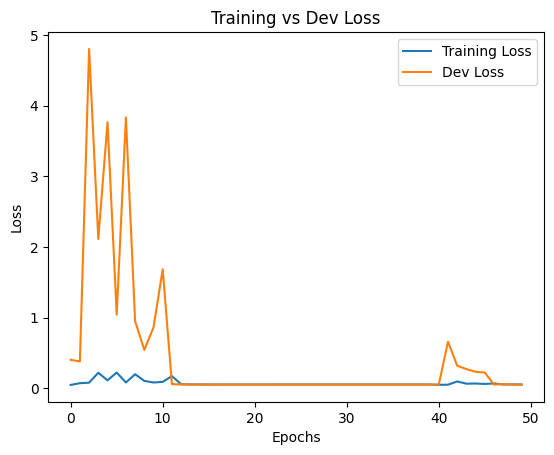

In [ ]:
# Train the model
history = model.fit(
    train_dataset,               # Training dataset
    validation_data=dev_dataset, # Validation dataset (dev set)
    epochs=epoch_num,                   # Maximum epochs
    callbacks=[checkpoint_callback, train_val_metrics, real_time_charting],  # Include checkpoint callback
)

# Print the epoch the training stopped at
print(f"Training stopped at epoch {len(history.epoch)}")

import matplotlib.pyplot as plt
import json
from google.colab import files

# Save history as a JSON file
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Download the saved JSON file to your local machine
files.download('history.json')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Dev Loss')
plt.title('Training vs Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from google.colab import files

class DownloadModelCallback(Callback):
    def __init__(self, download_model_path):
        super().__init__()
        self.download_model_path = download_model_path

    def on_train_end(self, logs=None):
        # Save the model
        self.model.save(self.download_model_path)
        print(f"Model saved to {self.download_model_path}")

        # Trigger the download
        files.download(self.download_model_path)
        print(f"Model downloaded to your local machine.")

# Path to save the model
download_model_path = 'final_model.keras'

# Add the custom callback
download_callback = DownloadModelCallback(download_model_path)

from tensorflow.keras.models import load_model
# Path to the model of interest in Google Drive
model_path = '/content/drive/My Drive/Senior Project/Models/final_model.keras'
# Load the model from the .keras file
model = load_model(model_path, compile=False)  # Use compile=False to avoid recompilation

from tensorflow.keras.losses import BinaryFocalCrossentropy

# Create the loss object
focal_loss = BinaryFocalCrossentropy(
    apply_class_balancing=False,  # Manually handle class weights if needed
    alpha=0.2,                  # Balancing factor (set based on your dataset)
    gamma=2.0,                   # Focusing parameter
    from_logits=False,           # Use False if your output layer has sigmoid activation
    reduction='sum_over_batch_size',  # Default reduction
    name='binary_focal_crossentropy'
)

# Add AUC (ROC-AUC) metric
model.compile(
    optimizer='adam',
    loss= focal_loss,
    metrics=[
        'accuracy',                 # Accuracy
        AUC(name="roc_auc", curve='ROC'),  # ROC-AUC metric
        Precision(name="precision"),       # Precision
        Recall(name="recall")              # Recall
    ]
)

# Continue training for a total of 50 epochs
history = model.fit(
    train_dataset,                 # Replace with your training dataset
    validation_data=dev_dataset,   # Replace with your validation dataset
    epochs=50,                     # Total number of epochs (including previously completed ones)
    initial_epoch=43,              # Start training from epoch 39
    callbacks=[checkpoint_callback, download_callback]  # Add callbacks as needed
)

Epoch 44/50
     76/Unknown 799s 10s/step - accuracy: 0.9173 - loss: 0.1456 - precision: 0.3121 - recall: 0.0071 - roc_auc: 0.7186

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 44: saving model to model_latest.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 896s 12s/step - accuracy: 0.9178 - loss: 0.1444 - precision: 0.3156 - recall: 0.0072 - roc_auc: 0.7201 - val_accuracy: 0.9563 - val_loss: 1.4845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4999
Epoch 45/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9185 - loss: 0.3072 - precision: 0.7703 - recall: 0.0047 - roc_auc: 0.6083
Epoch 45: saving model to model_latest.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 724s 9s/step - accuracy: 0.9189 - loss: 0.3045 - precision: 0.7708 - recall: 0.0047 - roc_auc: 0.6099 - val_accuracy: 0.9563 - val_loss: 3.1004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 46/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9196 - loss: 0.5276 - precision: 0.5211 - recall: 0.0492 - roc_auc: 0.6791
Epoch 46: saving model to model_latest.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 759s 10s/step - accuracy: 0.9201 - loss: 0.5227 - precision: 0.521

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded to your local machine.
